In [1]:
# !pip3 install numpy
# !pip3 install pyrocko

In [3]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import Counter

In [656]:
# Import the velocity model from https://colab.research.google.com/github/yetinam/pyocto/blob/main/examples/02_velocity_models.ipynb#scrollTo=1c52ed9e-d9c1-4fa6-a549-de702bc9d439
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

--2023-12-27 14:27:56--  https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv
Resolving github.com (github.com)... 20.29.134.23
Connecting to github.com (github.com)|20.29.134.23|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yetinam/pyocto/main/tests/data/graeber.csv [following]
--2023-12-27 14:27:56--  https://raw.githubusercontent.com/yetinam/pyocto/main/tests/data/graeber.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 395 [text/plain]
Saving to: ‘graeber.csv’

graeber.csv         100%[===================>]     395  --.-KB/s    in 0s      

2023-12-27 14:27:57 (64.2 MB/s) - ‘graeber.csv’ saved [395/395]



## Input Data

In [4]:
picks = pd.read_csv("~/notebooks/data/phase_association/pick",index_col=0)
stations = pd.read_csv("~/notebooks/data/phase_association/stations",index_col=0)

In [5]:
picks

,station,phase,time
0,FS09B,P,2012-10-01T00:04:09.141700Z
1,FS09B,P,2012-10-01T00:36:41.601700Z
2,FS09B,P,2012-10-01T00:55:43.061700Z
3,FS09B,P,2012-10-01T01:16:07.681700Z
4,FS09B,P,2012-10-01T01:41:37.561700Z
...,...,...,...
2444,M14B,S,2012-10-01T19:43:53.779925Z
2445,M14B,S,2012-10-01T21:19:41.539925Z
2446,M14B,S,2012-10-01T21:38:06.599925Z
2447,M14B,S,2012-10-01T23:08:32.799925Z


  ## Velocoty Models

In [6]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)

In [796]:
?pyocto.OctoAssociator.from_area

## Create a 1D velocity model

In [769]:
layers = pd.read_csv("graeber.csv")
layers

,depth,vp,vp_grad,vs,vs_grad,x,y
0,0.0,6.1,0.00,3.6,0.00,1.0,0.0
1,10.0,6.1,0.03,3.6,0.02,1.0,0.0
2,20.0,6.4,0.01,3.8,0.01,1.0,0.0
3,30.0,6.5,0.06,3.8,0.04,1.0,0.0
4,40.0,7.1,0.00,4.2,0.00,1.0,0.0
5,50.0,7.1,0.02,4.2,0.01,1.0,0.0
6,60.0,7.3,0.06,4.3,0.04,1.0,0.0
7,70.0,7.9,0.02,4.7,0.01,1.0,0.0
8,80.0,8.1,0.04,4.8,0.02,1.0,0.0
9,90.0,8.5,0.00,5.1,0.00,1.0,0.0


In [770]:
model_path = "velocity_model"
pyocto.VelocityModel1D.create_model(layers, 1., 400, 250, model_path)

In [771]:
velocity_model_1d = pyocto.VelocityModel1D(model_path, tolerance=2.0)

## The OctoAssociator class

In [7]:
associator = pyocto.OctoAssociator.from_area(
    lat=(40, 43.5),
    lon=(-126.5, -123),
    zlim=(0, 50),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=3,
    n_p_picks=2,
    n_s_picks=1,
    n_p_and_s_picks=1,
)

In [8]:
associator.crs

<Projected CRS: +proj=tmerc +lat_0=41.75 +lon_0=-124.75 +units=km  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
associator.transform_stations(stations)
stations

,id,longitude,latitude,elevation,x,y,z
0,FS09B,-124.808502,40.438702,-2161.0,-4.963595,-145.625525,2.161
1,FS13B,-124.806503,40.493099,-2332.0,-4.790124,-139.585196,2.332
2,G10B,-125.553299,40.677898,-2936.0,-67.913996,-118.755232,2.936
3,G19B,-125.773598,41.307400,-3071.0,-85.719842,-48.651523,3.071
4,G25B,-124.586098,41.919899,-430.0,13.596424,18.883688,0.430
5,G27B,-126.016701,41.916599,-3480.0,-105.085006,19.280241,3.480
6,J09B,-124.726997,43.151001,-252.0,1.871087,155.626312,0.252
7,M12B,-124.946098,42.183998,-1045.0,-16.199984,48.223921,1.045
8,M14B,-124.589699,40.985001,-638.0,13.490014,-84.949193,0.638


## Convert the timestamps to floats

In [10]:
picks["time"] = picks["time"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ'))

In [11]:
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
picks

,station,phase,time
0,FS09B,P,1.349050e+09
1,FS09B,P,1.349052e+09
2,FS09B,P,1.349053e+09
3,FS09B,P,1.349054e+09
4,FS09B,P,1.349056e+09
...,...,...,...
2444,M14B,S,1.349121e+09
2445,M14B,S,1.349126e+09
2446,M14B,S,1.349127e+09
2447,M14B,S,1.349133e+09


In [806]:
type(1.349050e+09)

float

## Delete unnecessary columns

In [807]:
# picks.drop(columns="Unnamed: 0", inplace=True)
# picks

In [808]:
# stations.drop(columns="Unnamed: 0", inplace=True)
# stations

## Apply  the associator

In [12]:
events, assignments = associator.associate(picks, stations)

In [13]:
events

,idx,time,x,y,z,picks
0,0,1.349056e+09,23.934284,-134.510293,0.390625,3
1,1,1.349061e+09,-4.086341,-40.002008,26.171875,3
2,2,1.349063e+09,15.761602,17.160262,33.203125,3
3,3,1.349068e+09,-6.421393,-148.991401,1.953125,3
4,4,1.349069e+09,-37.944597,-25.520899,0.390625,3
5,5,1.349071e+09,-18.096654,40.025170,8.203125,3
6,6,1.349087e+09,-98.655952,-149.753565,18.359375,3
7,7,1.349087e+09,-61.295118,30.117043,29.296875,3
8,8,1.349090e+09,-43.782227,-129.937311,2.734375,3
9,9,1.349091e+09,30.939441,-137.558947,36.328125,3


In [14]:
Counter(events['picks'])

Counter({3: 13, 4: 1})

In [15]:
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,2012-10-01 01:51:10.190768+00:00,23.934284,-134.510293,0.390625,3,40.538469,-124.467487,0.390625
1,1,2012-10-01 03:02:35.536306+00:00,-4.086341,-40.002008,26.171875,3,41.389822,-124.798858,26.171875
2,2,2012-10-01 03:41:02.176675+00:00,15.761602,17.160262,33.203125,3,41.904343,-124.560043,33.203125
3,3,2012-10-01 05:10:41.272429+00:00,-6.421393,-148.991401,1.953125,3,40.408381,-124.825650,1.953125
4,4,2012-10-01 05:27:03.323351+00:00,-37.944597,-25.520899,0.390625,3,41.519321,-125.204582,0.390625
5,5,2012-10-01 05:55:25.648614+00:00,-18.096654,40.025170,8.203125,3,42.110145,-124.968802,8.203125
6,6,2012-10-01 10:16:32.886213+00:00,-98.655952,-149.753565,18.359375,3,40.395702,-125.912027,18.359375
7,7,2012-10-01 10:26:47.186818+00:00,-61.295118,30.117043,29.296875,3,42.018766,-125.490041,29.296875
8,8,2012-10-01 11:20:42.479977+00:00,-43.782227,-129.937311,2.734375,3,40.578838,-125.267101,2.734375
9,9,2012-10-01 11:28:25.077608+00:00,30.939441,-137.558947,36.328125,3,40.510783,-124.384951,36.328125


In [16]:
assignments

,event_idx,pick_idx,residual,station,phase,time
0,0,2003,0.899993,M12B,P,1.349056e+09
1,0,2209,-0.886591,M14B,P,1.349056e+09
2,0,2395,-0.013402,M14B,S,1.349056e+09
3,1,1889,-0.017251,J09B,P,1.349061e+09
4,1,2220,0.043624,M14B,P,1.349061e+09
5,1,2398,-0.026373,M14B,S,1.349061e+09
6,2,2015,0.009871,M12B,P,1.349063e+09
7,2,2139,0.001263,M12B,S,1.349063e+09
8,2,2223,-0.011134,M14B,P,1.349063e+09
9,3,20,-0.055572,FS09B,P,1.349068e+09


In [17]:
pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,0,2012-10-01 01:51:10.190768+00:00,23.934284,-134.510293,0.390625,3,40.538469,-124.467487,0.390625,0,2003,0.899993,M12B,P,1.349056e+09
1,0,2012-10-01 01:51:10.190768+00:00,23.934284,-134.510293,0.390625,3,40.538469,-124.467487,0.390625,0,2209,-0.886591,M14B,P,1.349056e+09
2,0,2012-10-01 01:51:10.190768+00:00,23.934284,-134.510293,0.390625,3,40.538469,-124.467487,0.390625,0,2395,-0.013402,M14B,S,1.349056e+09
3,1,2012-10-01 03:02:35.536306+00:00,-4.086341,-40.002008,26.171875,3,41.389822,-124.798858,26.171875,1,1889,-0.017251,J09B,P,1.349061e+09
4,1,2012-10-01 03:02:35.536306+00:00,-4.086341,-40.002008,26.171875,3,41.389822,-124.798858,26.171875,1,2220,0.043624,M14B,P,1.349061e+09
5,1,2012-10-01 03:02:35.536306+00:00,-4.086341,-40.002008,26.171875,3,41.389822,-124.798858,26.171875,1,2398,-0.026373,M14B,S,1.349061e+09
6,2,2012-10-01 03:41:02.176675+00:00,15.761602,17.160262,33.203125,3,41.904343,-124.560043,33.203125,2,2015,0.009871,M12B,P,1.349063e+09
7,2,2012-10-01 03:41:02.176675+00:00,15.761602,17.160262,33.203125,3,41.904343,-124.560043,33.203125,2,2139,0.001263,M12B,S,1.349063e+09
8,2,2012-10-01 03:41:02.176675+00:00,15.761602,17.160262,33.203125,3,41.904343,-124.560043,33.203125,2,2223,-0.011134,M14B,P,1.349063e+09
9,3,2012-10-01 05:10:41.272429+00:00,-6.421393,-148.991401,1.953125,3,40.408381,-124.825650,1.953125,3,20,-0.055572,FS09B,P,1.349068e+09


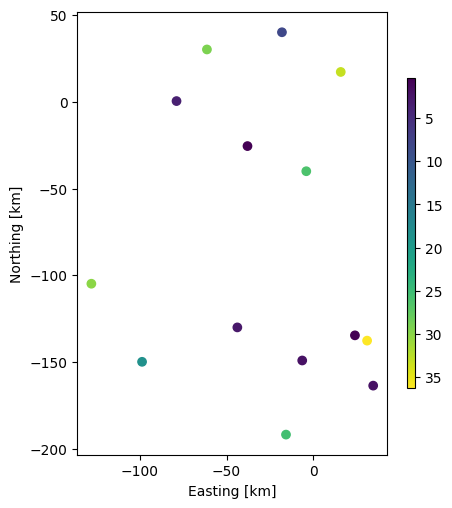

In [18]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

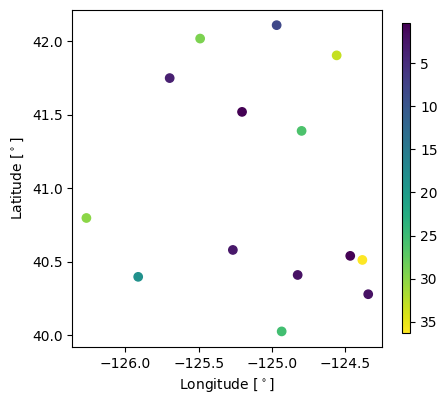

In [19]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.set_xlabel("Longitude [$^\circ$]")
ax.set_ylabel("Latitude [$^\circ$]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["longitude"], events["latitude"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

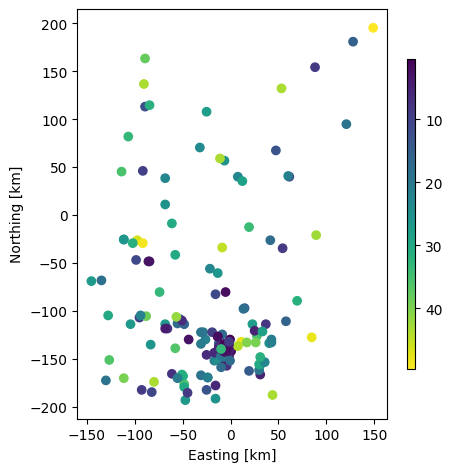

In [655]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()
